In [1]:
import mbuild as mb
import matplotlib.pyplot as plt
import numpy as np
from foyer import Forcefield
from calc_numberdensity import calc_number_density

In [2]:
water = mb.load('files/tip3p.mol2')
water.name = 'SOL'

/Users/raymatsumoto/anaconda3/envs/mosdef36/lib/python3.6/site-packages/mdtraj/formats/mol2.py:203: FutureWarning: read_table is deprecated, use read_csv instead.
  index_col=0, header=None, sep="\s+", engine='python')


In [3]:
c_ff = Forcefield('files/carbon.xml')
spce = Forcefield('files/spce.xml')

In [ ]:
try:
    GraphenePoreSolvent = mb.recipes.GraphenePoreSolvent
except ImportError:
    try:
        import porebuilder
        GraphenePoreSolvent = porebuilder.porebuilder.GraphenePoreSolvent
    except (ImportError, AttributeError):
        pass

In [ ]:
system = GraphenePoreSolvent(pore_depth=2,side_dim=2,
                    n_sheets=3,pore_width=1.2,x_bulk=1.5,
                    solvent=water,n_solvent=600)
box = mb.Box(system.periodicity)

In [ ]:
water = mb.Compound()
graphene = mb.Compound()
for child in system.children:
    if child.name == 'SOL':
        water.add(mb.clone(child))
    else:
        graphene.add(mb.clone(child))

water_pmd = spce.apply(water, residues='SOL')           
pore_pmd = c_ff.apply(graphene)

In [ ]:
system = water_pmd + pore_pmd
system.box[:3] = box.maxs * 10.0
system.save('init.gro', overwrite=True, combine='all')
system.save('init.top', overwrite=True, combine='all')

In [ ]:
!gmx grompp -f files/nvt.mdp -c init.gro -p init.top -o nvt.tpr

In [ ]:
!gmx mdrun -deffnm nvt

In [4]:
reference_num_den = np.loadtxt('ref_data/numden.txt')

In [5]:
gro_file = 'nvt.gro'
trj_file = 'nvt.trr'
top_file = 'init.top'

In [6]:
box_range = [0.838, 2.038]
mins = [1.684, 0, 0]
maxs = [3.403, 0, 0]
area = 3.78

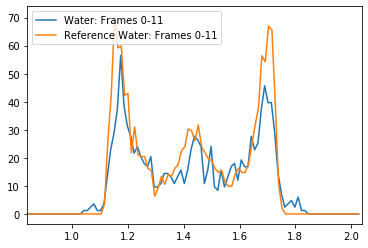

In [7]:
plt.figure()
plt.xlim(box_range[0], box_range[1])
rho, bins = calc_number_density(gro_file, trj_file, top_file, area, dim=1,
                                    box_range=box_range, n_bins=100, frame_range=range(0,11),
                                    maxs=maxs, mins=mins)
plt.plot(bins, rho[0], label='Water: Frames {}-{}'.format(0,11))
plt.plot(reference_num_den[:,0], reference_num_den[:,1], label='Reference Water: Frames {}-{}'.format(0,11))
plt.legend()
plt.savefig('number-density.pdf')